# 1. Breakdown of Face Preprocess

This notebook explains the preprocess step, which I have packaged up nicely in the `FacePreprocess` class. 
The models I used are:
    
* Facial Detector &rarr; [OpenCV SSD](https://learnopencv.com/tag/ssd/)
* Facial landmarks &rarr; [MediaPipe](https://developers.google.com/mediapipe)

In [26]:
import cv2
import mediapipe
import math
import numpy as np
import pandas as pd
import time
from PIL import Image
import matplotlib.pyplot as plt

## How to use `FacePreprocess`

This class is a convenient package which helps preprocess your image, ready to input to your facial recognition model. It will return a list of the faces detected and the boundary (top, bottom, left, right) on the original image.

In [27]:
# Class initialization
from modules.FacePreprocess import FacePreprocess
ssd_model = r'./models/ssd/deploy.prototxt.txt'
ssd_weights = r'./models/ssd/res10_300x300_ssd_iter_140000.caffemodel'
processor = FacePreprocess(ssd_model, ssd_weights)

In [28]:
# Using the `preproc` function.
img_path = './dataset/joy/img_1.jpg'
img = cv2.imread(img_path)
processed_img = processor.preproc(img)[0][0]

Text(0.5, 1.0, 'Preprocessed')

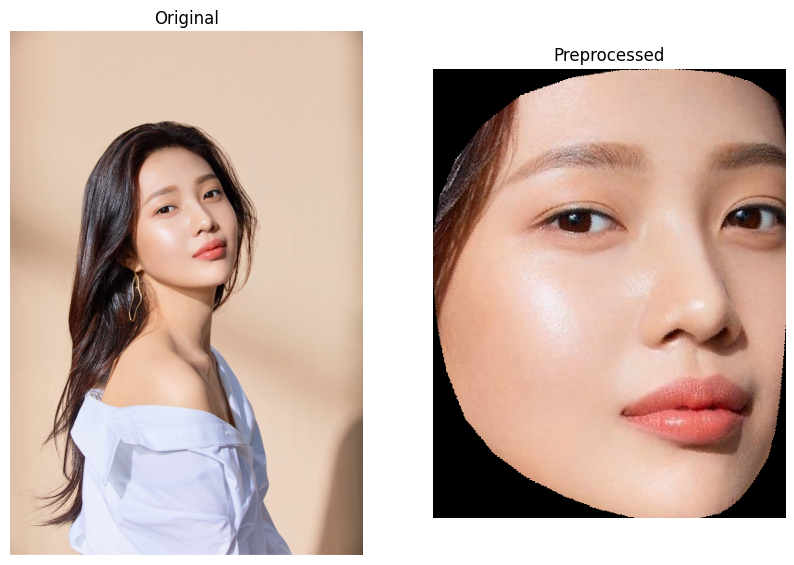

In [29]:
# Plot using matplotlib
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)  
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original")
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Preprocessed")

## Step 1: Detect the face 

We will use OpenCV SSD's pretrained face detection model.

In [30]:
# Initalize the model
detector = cv2.dnn.readNetFromCaffe(ssd_model, ssd_weights)

# Read image
img_path = './dataset/joy/img_1.jpg'
img = cv2.imread(img_path)

In [31]:
# original image size
img_h, img_w = img.shape[:2]

# convert image to target size (detector expects (1, 3, 300, 300) input)
resized = cv2.resize(img, (300, 300))
aspect_ratio_x, aspect_ratio_y = (img_w / 300), (img_h / 300)
imageBlob = cv2.dnn.blobFromImage(image = resized)

# input image into detector
detector.setInput(imageBlob)
detections = detector.forward() 

# get results
column_labels = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"]
detections_df = pd.DataFrame(detections[0][0], columns = column_labels)
detections_df.head()

,img_id,is_face,confidence,left,top,right,bottom
0,0.0,1.0,0.999998,0.349053,0.209846,0.654274,0.486333
1,0.0,1.0,0.146972,0.475585,0.315269,0.645090,0.481336
2,0.0,1.0,0.124219,4.161631,4.003901,4.840766,4.983162
3,0.0,1.0,0.118568,0.159970,4.005783,0.833872,4.987526
4,0.0,1.0,0.111647,4.153129,0.030713,4.837017,0.986205


The SSD model will return a list of face candidates, and now we want to filter the results where `is_face` is `True`, and where the confidence is over a certain threshold (I will use `0.9` here).

In [32]:
# filter the results
confidence_treshold = 0.9
detections_df = detections_df[detections_df['is_face'] == 1]
detections_df = detections_df[detections_df['confidence'] >= confidence_treshold]

# rescale back to 300x300 (results are in [0:1])
for i in ['left', 'bottom', 'right', 'top']:
    detections_df[i] = (detections_df[i] * 300).astype(int)

detections_df

,img_id,is_face,confidence,left,top,right,bottom
0,0.0,1.0,0.999998,104,62,196,145


Now let's check the results!

(-0.5, 1377.5, 2047.5, -0.5)

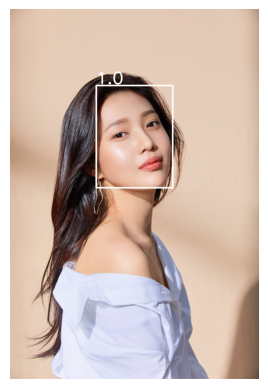

In [33]:
detected_face = img.copy() # we don't want to modify the original image

# the image may contain more than one face, and the detector is able to detect those as well
# but since we only have one face in the sample image, we'll extract the first row
row = detections_df.iloc[0]

left = int(row['left']*aspect_ratio_x)
right = int(row['right']*aspect_ratio_x)
top = int(row['top']*aspect_ratio_y)
bottom = int(row['bottom']*aspect_ratio_y)

cv2.rectangle(
    img = detected_face, 
    pt1 = (left, top), 
    pt2 = (right, bottom), 
    color = (255, 255, 255), 
    thickness = 8,
)
cv2.putText(
    img = detected_face, 
    text = str(round(row['confidence'], 3)), 
    org = (left, top-10), 
    fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
    fontScale = 3, 
    color = (255, 255, 255),
    thickness = 8,
)

# plt has different color channels than opencv
plt.imshow(cv2.cvtColor(detected_face,cv2.COLOR_BGR2RGB))
plt.axis('off')

## Step 2: Normalization using MediaPipe

In a face recognition task, we only want to focus on the face, so in this step we're going to isolate the face oval using MediaPipe's facial landmark model.

In [34]:
# build the facial landmarks detector - Mediapipe 
mp_face_mesh = mediapipe.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True, 
    max_num_faces = 1,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)

(-0.5, 1377.5, 2047.5, -0.5)

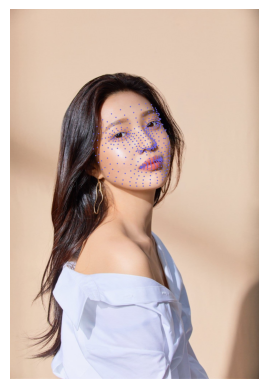

In [35]:
# find facial landmarks
results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
landmarks = results.multi_face_landmarks[0]

# rescale the coordinates (results are in [0:1])
mesh_points = np.array([np.multiply((p.x, p.y), (img_w, img_h)).astype(int) for p in landmarks.landmark])

# let's visualize the results
face_landmarks = img.copy() # we don't want to modify the original image
for point in mesh_points:
    cv2.circle(face_landmarks, (point[0], point[1]), 2, (214, 99, 112) , 2)
plt.imshow(cv2.cvtColor(face_landmarks, cv2.COLOR_BGR2RGB))
plt.axis('off')

Now, let's isolate the face oval.

In [36]:
# face oval landmarks
FACE_OVAL = [149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109, 10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176]

# draw line around oval
face_oval = img.copy() # we don't want to modify the original image
cv2.polylines(face_oval, [mesh_points[FACE_OVAL]], True, (255, 255, 0), 2)

# mask out the rest of the iamge
routes = [(i[0], i[1]) for i in mesh_points[FACE_OVAL]]
tmp = img.copy() # we don't want to modify the original image

# extracting face oval
mask = np.zeros((tmp.shape[0], tmp.shape[1]))
mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
mask = mask.astype(bool)
masked = np.zeros_like(tmp)
masked[mask] = tmp[mask]

(-0.5, 1377.5, 2047.5, -0.5)

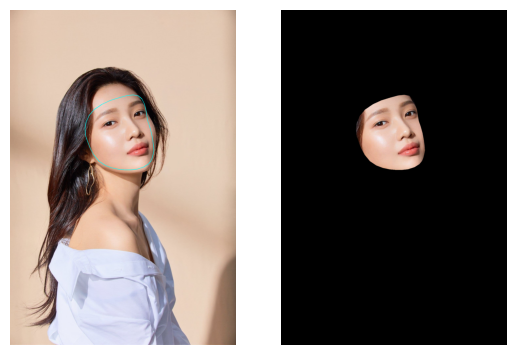

In [37]:
# Plot using matplotlib
fig = plt.figure()
fig.add_subplot(1, 2, 1)  
plt.imshow(cv2.cvtColor(face_oval, cv2.COLOR_BGR2RGB))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Step 3: Align the eyes

We want both eyes to be parallel with the x-axis, which can help increase the accuracy of your facial recognition model. We can use the results from the face mesh to detect both eyes and compute the angle of rotation.

(-0.5, 1377.5, 2047.5, -0.5)

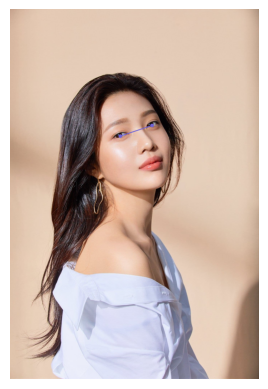

In [38]:
# eye landmarks
LEFT_EYE = [33, 246, 133, 155] # left, top, right, bottom
RIGHT_EYE = [362, 398, 263, 249] # left, top, right, bottom

eye_align = img.copy() # we don't want to modify the original image

# eye coordinates
left_xy, right_xy = mesh_points[LEFT_EYE], mesh_points[RIGHT_EYE]

# find the center of both eyes
left_center = (int((left_xy[0][0]+left_xy[2][0])/2), int((left_xy[1][1]+left_xy[3][1])/2))
right_center = (int((right_xy[0][0]+right_xy[2][0])/2), int((right_xy[1][1]+right_xy[3][1])/2))

# let's visualize the results
cv2.circle(eye_align, left_center, 2, (214, 99, 112), 15)
cv2.circle(eye_align, right_center, 2, (214, 99, 112), 15)
cv2.line(eye_align, right_center, left_center, (214, 99, 112), 4)
plt.imshow(cv2.cvtColor(eye_align, cv2.COLOR_BGR2RGB))
plt.axis('off')

Now that we've found the center of the eyes, let's use basic trigonometry to find the angle of rotation

In [39]:
def euclidDist(x1, y1, x2, y2):
    return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

rotate clockwise
angle of rotation: -18.532556530052673


(-0.5, 1377.5, 2047.5, -0.5)

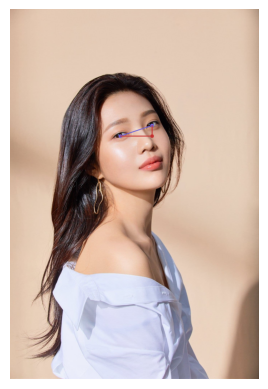

In [40]:
# find rotate direction
if left_center[1] >= right_center[1]:
    point_3rd = (right_center[0], left_center[1])
    direction = -1 
    print('rotate clockwise')
else:
    point_3rd = (left_center[0], right_center[1])
    direction = 1 
    print('rotate counterclockwise')

# plot triangle 
cv2.circle(eye_align, point_3rd, 2, (47, 47, 196) , 15)
cv2.line(eye_align,left_center, point_3rd,(47, 47, 196), 4)
cv2.line(eye_align,right_center, point_3rd,(47, 47, 196), 4)

a = euclidDist(left_center[0], left_center[1], point_3rd[0], point_3rd[1])
b = euclidDist(right_center[0], right_center[1], left_center[0], left_center[1])
c = euclidDist(right_center[0], right_center[1], point_3rd[0], point_3rd[1])

# if eyes are already aligned, no need to rotate
try:
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    angle = (np.arccos(cos_a) * 180) / math.pi
    angle = 90 - angle if direction == -1 else angle
except: 
    print('no rotation needed')
    angle = 0

rotation = direction*angle
print('angle of rotation:', rotation)

# visualize
plt.imshow(cv2.cvtColor(eye_align, cv2.COLOR_BGR2RGB))
plt.axis('off')

Now that we've found the angle of rotation, let's rotate the isolated face image

In [41]:
rotated_img = Image.fromarray(masked)
rotated_img = np.array(rotated_img.rotate(rotation))

(-0.5, 1377.5, 2047.5, -0.5)

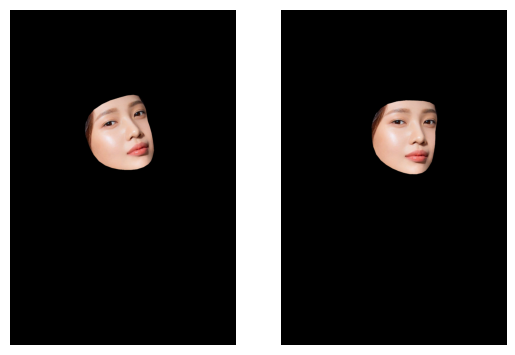

In [42]:
fig = plt.figure()
fig.add_subplot(1, 2, 1)  
plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Step 4: Final cleanup

We're almost there, let's cleanup the image a little bit. Let's crop out the black borders. 

In [43]:
def rotate(pt, radians, origin):
    x, y = pt
    offset_x, offset_y = origin
    adjusted_x, adjusted_y = (x - offset_x), (y - offset_y)

    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return [qx, qy]

In [44]:
# Find new facial boundaries 
center = [int(rotated_img.shape[1]/2), int(rotated_img.shape[0]/2)]
top = rotate(mesh_points[10] , np.radians(rotation), center)[1]
bottom = rotate(mesh_points[152] , np.radians(rotation), center)[1]
left = rotate(mesh_points[234] , np.radians(rotation), center)[0]
right = rotate(mesh_points[454] , np.radians(rotation), center)[0]

# crop image based on new boundary
processed_img = rotated_img[int(top):int(bottom), int(left):int(right)]

(-0.5, 387.5, 447.5, -0.5)

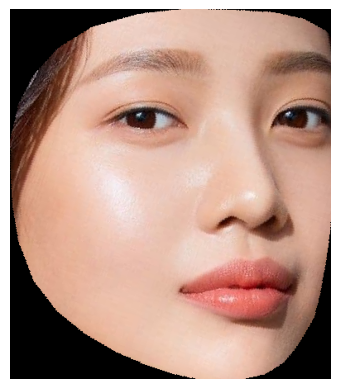

In [45]:
# visualize
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')